<a href="https://colab.research.google.com/github/widyamelia26/Javanese-Letter-Recognition/blob/main/aksara_jawa_EfficientNetb0_(74%2C5__).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

# Check if the dataset already exists
if test -e "aksara-jawa-dataset.zip"; then
    rm -rf aksara-jawa-dataset.zip ./data ./data-test
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
else
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
fi

# Remove unnecessary files
rm -f ./data/LICENSE ./data/LICENSE.md ./data/README.md
rm -f ./data-test/LICENSE ./data-test/LICENSE.md ./data-test/README.md

Dataset URL: https://www.kaggle.com/datasets/rfahrur6045/aksara-jawa-dataset
License(s): unknown

Archive:  aksara-jawa-dataset.zip
  inflating: data-test/ba/test-ba1.png  
  inflating: data-test/ba/test-ba2.png  
  inflating: data-test/ca/test-ca1.png  
  inflating: data-test/ca/test-ca2.png  
  inflating: data-test/ca/test-ca3.png  
  inflating: data-test/ca/test-ca4.png  
  inflating: data-test/da/test-da1.png  
  inflating: data-test/da/test-da2.png  
  inflating: data-test/dha/test-dha1.png  
  inflating: data-test/dha/test-dha2.png  
  inflating: data-test/dha/test-dha3.png  
  inflating: data-test/ga/test-ga1.png  
  inflating: data-test/ga/test-ga2.png  
  inflating: data-test/ga/test-ga3.png  
  inflating: data-test/ha/ha_test1.png  
  inflating: data-test/ha/ha_test2.png  
  inflating: data-test/ha/ha_test3.png  
  inflating: data-test/ha/ha_test4.png  
  inflating: data-test/ha/ha_test5.png  
  inflating: data-test/ja/test-ja1.png  
  inflating: data-test/ja/test-ja2.png  
 

100%|██████████| 193M/193M [00:07<00:00, 26.2MB/s]


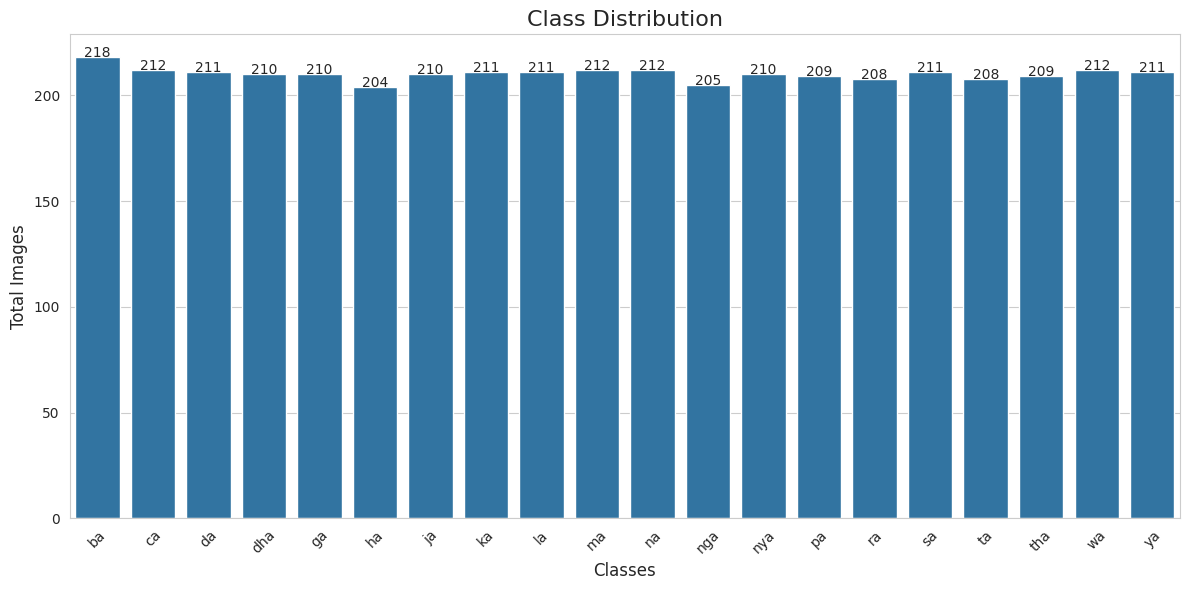

In [2]:
import glob

import matplotlib.pyplot as plt
import seaborn as sns


train_path = "/content/data"
test_path = "/content/data-test"
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]
class_distribution = {}

# Put image paths to dictionary using class names as keys.
for class_name in class_names:
    class_distribution[class_name] = len(glob.glob(f"{train_path}/{class_name}/*"))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))

plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Total Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels of each bar.
for index, value in enumerate(class_distribution.values()):
    plt.text(index, value, str(value), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

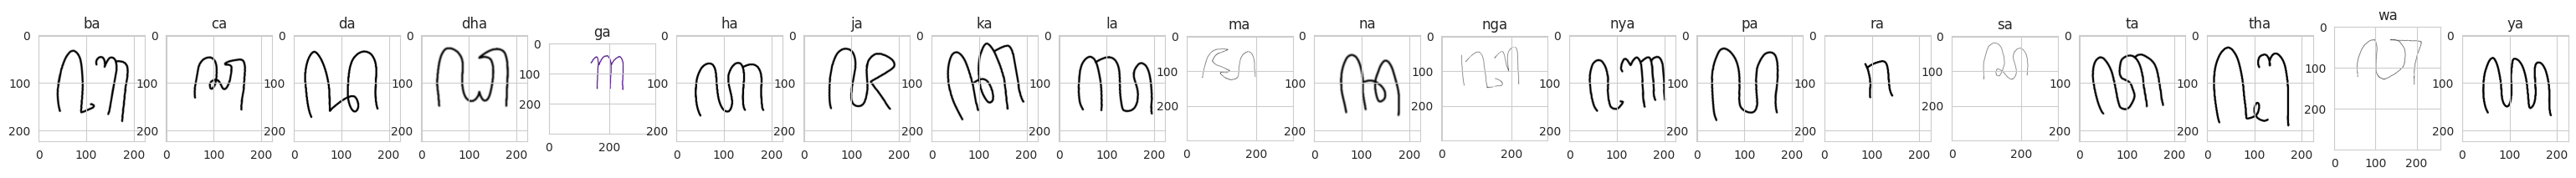

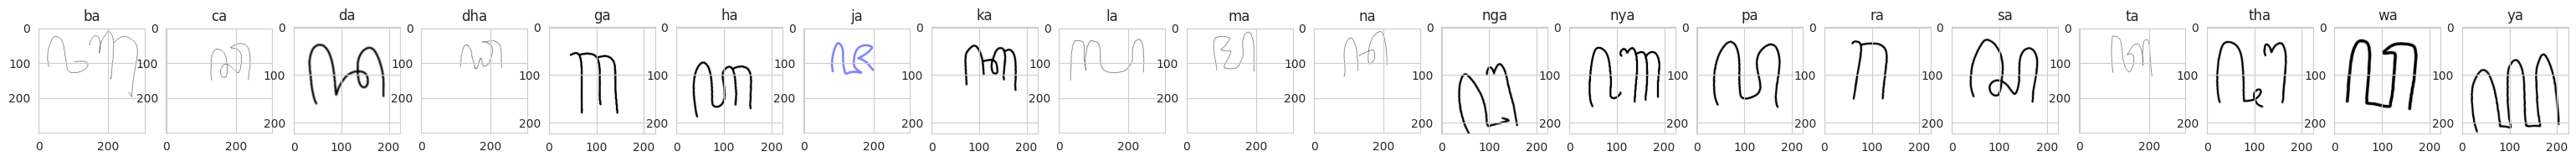

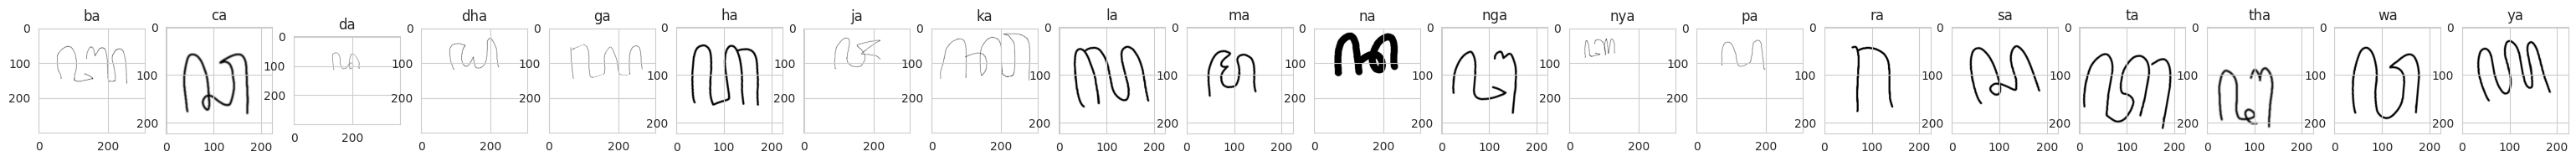

In [3]:
import cv2
import numpy as np


def plot_sample_images(class_names):
    fig, axis = plt.subplots(1, len(class_names), figsize=[39,45])

    for index, (class_name, count) in enumerate(class_distribution.items()):
        # Randomly choose images to plot.
        random_index = np.random.randint(0, count)
        img_read = cv2.imread(
            glob.glob(f"{train_path}/{class_name}/*")[random_index]
        )

        axis[index].imshow(img_read)
        axis[index].set_title(class_name)

# Plot several samples of each class.
for i in range(0, 3):
    plot_sample_images(class_names)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet


# Data generator for traning and validation.
train_data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,  # Aksara shouldn't be flipped vertically
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],
    validation_split=0.2 # 20% of images to be used for validation.
    )

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    shuffle=True
    )

validation_data_generator = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2 # 20% of images to be used for validation.
    )

validation_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    shuffle=False
)

Found 3369 images belonging to 20 classes.
Found 834 images belonging to 20 classes.


In [5]:
# Data generator for evaluation.
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    shuffle = False  # Keep this False for confusion matrix.
)

Found 55 images belonging to 20 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_model (num_classes):
    """
    Create model using EfficientNetB0 architecture with custom modifications
    """
    # Load EfficientNetB0 instead of MobileNetV2
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),  # Increased input size
        pooling=None
    )

    # Fine-tune more layers
    for layer in base_model.layers[:-30]:  # Freeze fewer layers
        layer.trainable = False

    # Build custom top layers
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs)

    # Enhanced feature extraction
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(1024, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)  # Using swish activation
    x = Dropout(0.4)(x)

    # Second dense block
    x = Dense(512, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)
    x = Dropout(0.3)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.0001))(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model, base_model

def visualize_model_architecture(model):
    """
    Visualize the model architecture using plot_model
    """
    # Create the model flowchart
    plot_model(
        model,
        to_file='cnn_model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='LR'
    )

    # Display the flowchart
    plt.figure(figsize=(15, 10))
    img = plt.imread('cnn_model.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Architecture')
    plt.show()

In [20]:
def create_callbacks():
    """
    Create enhanced callbacks for better training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,              # Increased patience
        restore_best_weights=True,
        min_delta=0.001          # Minimum change to qualify as an improvement
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,              # More aggressive LR reduction
        patience=8,              # Reduced patience for LR reduction
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return early_stopping, reduce_lr, checkpoint

def train_model(model, train_generator, validation_generator):
    """
    Enhanced training configuration with cosine decay learning rate
    """
    initial_learning_rate = 1e-3
    decay_steps = 50 * len(train_generator)

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate,
        decay_steps,
        alpha=1e-6
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=0.0001
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_efficientnet_aksara_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [13]:
def fine_tune_model(model, base_model, train_generator, validation_generator):
    early_stopping, reduce_lr, checkpoint = create_callbacks()

    # Fine-tuning: Create a new optimizer with a lower learning rate
    fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

    # Compile the model with the new optimizer
    model.compile(
        optimizer=fine_tune_optimizer,  # Use the new optimizer for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )

    return history_fine

In [14]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

Initial training with frozen base layers...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.3879 - loss: 2.2203
Epoch 1: val_accuracy improved from -inf to 0.47842, saving model to best_efficientnet_aksara_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 158s 551ms/step - accuracy: 0.3892 - loss: 2.2155 - val_accuracy: 0.4784 - val_loss: 1.9430 - learning_rate: 9.9901e-04
Epoch 2/50
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6836 - loss: 1.1946
Epoch 2: val_accuracy improved from 0.47842 to 0.54556, saving model to best_efficientnet_aksara_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 65s 300ms/step - accuracy: 0.6836 - loss: 1.1942 - val_accuracy: 0.5456 - val_loss: 1.6260 - learning_rate: 9.9606e-04
Epoch 3/50
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7387 - loss: 1.0452
Epoch 3: val_accuracy improved from 0.54556 to 0.54796, saving model to best_efficientnet_aksara_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 89s 333ms/step - accuracy: 0.7387 - loss: 1.0447 - val_accuracy: 0.5480 - val_loss: 1.7810 - lear

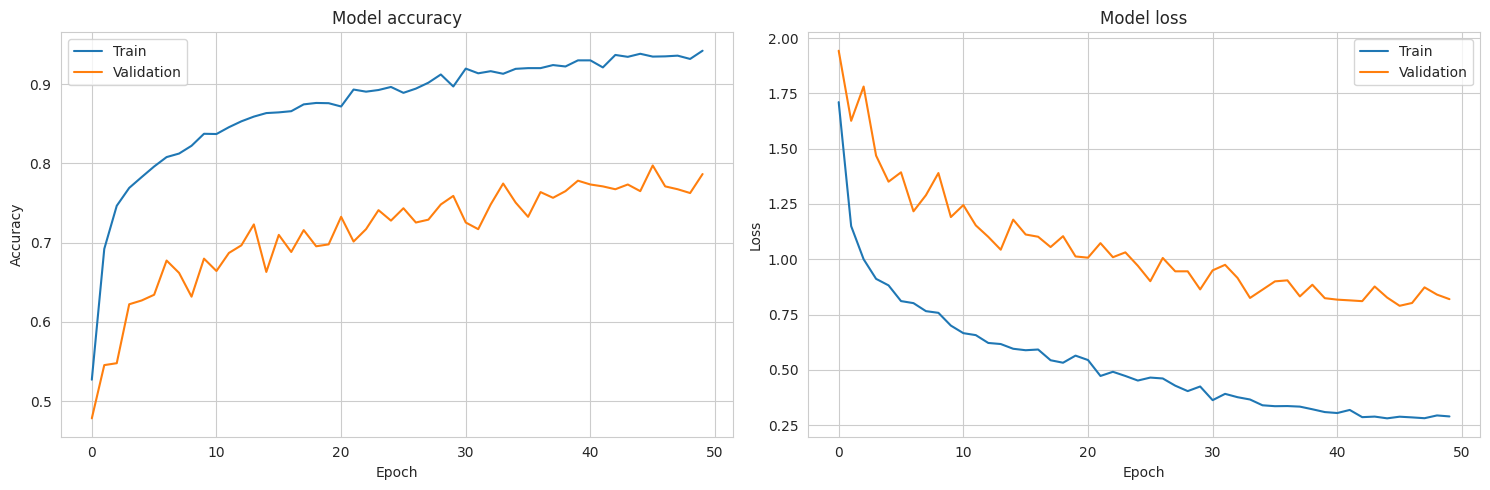

Fine-tuning the model...
Epoch 1/30
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9367 - loss: 0.2867
Epoch 1: val_accuracy improved from -inf to 0.74940, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 118s 407ms/step - accuracy: 0.9367 - loss: 0.2867 - val_accuracy: 0.7494 - val_loss: 0.8845 - learning_rate: 1.0000e-06
Epoch 2/30
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9276 - loss: 0.3010
Epoch 2: val_accuracy improved from 0.74940 to 0.79496, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 103s 298ms/step - accuracy: 0.9276 - loss: 0.3009 - val_accuracy: 0.7950 - val_loss: 0.8170 - learning_rate: 1.0000e-06
Epoch 3/30
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9338 - loss: 0.3021
Epoch 3: val_accuracy did not improve from 0.79496
211/211 ━━━━━━━━━━━━━━━━━━━━ 71s 330ms/step - accuracy: 0.9338 - loss: 0.3020 - val_accuracy: 0.7686 - val_loss: 0.8259 - learning_rate: 1.0000e-06
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━

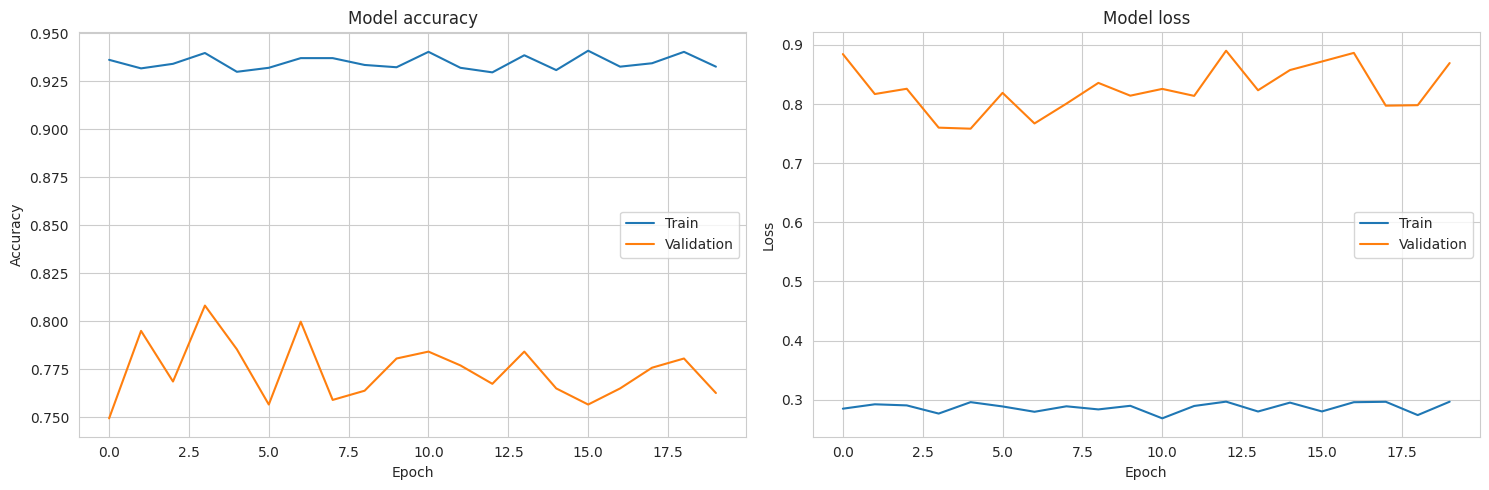

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


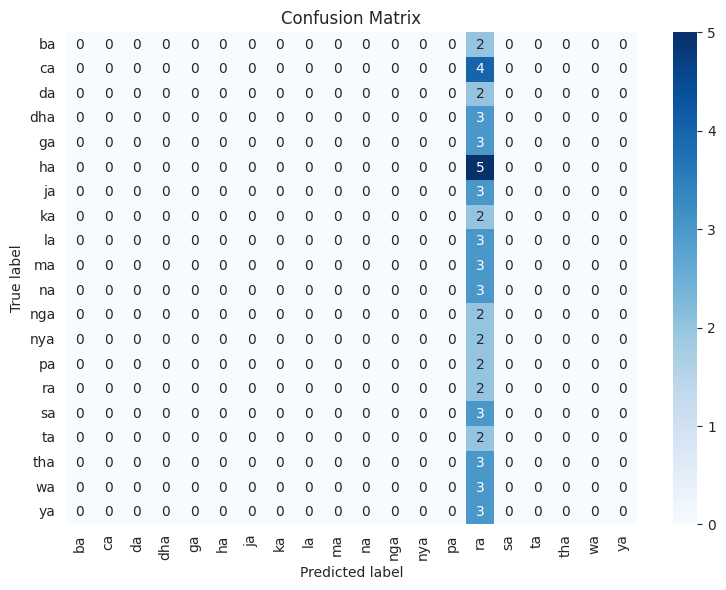

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Nama-nama kelas emosi
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]

def plot_confusion_matrix(model, test_generator): # Pass model as an argument
    """Plots the confusion matrix."""

    # Peroleh true labels dari test generator
    true_labels = test_generator.classes

    # Reset test generator sebelum prediksi
    test_generator.reset()

    # Dapatkan prediksi model pada data test
    predicted = model.predict(test_generator)
    predicted_labels = np.argmax(predicted, axis=1)

    # Hitung confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

def main(train_generator, validation_generator):
    # Create data generators
    train_generator, validation_generator = train_generator, validation_generator

    # Create model
    num_classes = len(train_generator.class_indices)
    model, base_model = create_model(num_classes) # Assuming create_model is defined elsewhere

    # Initial training with frozen base layers
    print("Initial training with frozen base layers...")
    history = train_model(model, train_generator, validation_generator) # Assuming train_model is defined elsewhere
    plot_training_history(history) # Assuming plot_training_history is defined elsewhere

    # Fine-tuning
    print("Fine-tuning the model...")
    history_fine = fine_tune_model(model, base_model, train_generator, validation_generator) # Assuming fine_tune_model is defined elsewhere
    plot_training_history(history_fine)

    # Plot the confusion matrix after training
    plot_confusion_matrix(model, test_generator) # Call the function to plot


if __name__ == "__main__":
    main(train_generator, validation_generator)